In [1]:
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./ml-latest-small/ratings.csv")
# df = pd.read_csv("/home/tianyou/ml-latest/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]
n_users, n_items

(610, 9724)

In [4]:
movie_movieId = df.movieId.unique().tolist()
movie_movieId.sort()
d = dict()
for i in range(0, len(movie_movieId)):
    d[movie_movieId[i]] = i

In [5]:
def user_item_matrix(data):
    ratings = np.zeros((n_users, n_items))
    for row in data.itertuples():
        ratings[row[1]-1, d[row[2]]] = row[3]
    return ratings

In [6]:
train_set, test_set = train_test_split(df)

In [7]:
ratings = user_item_matrix(df)
train = user_item_matrix(train_set)
test = user_item_matrix(test_set)
train

array([[4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 2., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [8]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.70%


In [9]:
def normalize(data, kind='user'):
    data2 = data.copy()
    data2[data2 == 0] = np.nan
    # print(np.nanmean(data[0]))
    if kind == 'user':
        for i in range(0, data2.shape[0]):
            data2[i] = data2[i] - np.nanmean(data2[i])
            # data[i][data[i] == 0] = np.nanmean(data[i])
            
    if kind == 'item':
        for j in range(0, data.shape[1]):
            data2.T[j] = data2.T[j] - np.nanmean(data2.T[j])

    data2[np.isnan(data2)] = 0
    return (data2)

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    user_norm_matrix = normalize(train, kind = 'user')
    item_norm_matrix = normalize(train, kind = 'item')

In [11]:
def similarity(ratings, kind='user', epsilon=1e-12):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [12]:
print(user_norm_matrix)

[[-0.33908046  0.         -0.33908046 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.         -1.12620579 ...  0.          0.
   0.        ]
 [-0.22580645  0.          0.         ...  0.          0.
   0.        ]
 [ 1.30727092  0.          0.         ...  0.          0.
   0.        ]]


In [13]:
user_norm_sim_matrix = similarity(user_norm_matrix, kind = 'user')
item_norm_sim_matrix = similarity(item_norm_matrix, kind = 'item')
user_sim_matrix = similarity(train, kind = 'user')
item_sim_matrix = similarity(train, kind = 'item')
print(user_sim_matrix)
print(user_norm_sim_matrix)

[[1.00000000e+00 3.59805901e-02 3.69362226e-02 ... 2.32540608e-01
  7.20418307e-02 1.26043164e-01]
 [3.59805901e-02 1.00000000e+00 3.17553041e-15 ... 5.06720497e-02
  3.47171882e-02 7.92074004e-02]
 [3.69362226e-02 3.17553041e-15 1.00000000e+00 ... 1.46988586e-02
  3.34640988e-15 1.89293732e-02]
 ...
 [2.32540608e-01 5.06720497e-02 1.46988586e-02 ... 1.00000000e+00
  8.00144720e-02 2.58209531e-01]
 [7.20418307e-02 3.47171882e-02 3.34640988e-15 ... 8.00144720e-02
  1.00000000e+00 3.24220974e-02]
 [1.26043164e-01 7.92074004e-02 1.89293732e-02 ... 2.58209531e-01
  3.24220974e-02 1.00000000e+00]]
[[ 1.00000000e+00  6.89237453e-04  4.52820591e-03 ...  6.14359105e-02
   5.55142332e-03  1.36591477e-02]
 [ 6.89237453e-04  1.00000000e+00  2.34234385e-14 ... -9.25599919e-03
  -8.06522996e-02  2.65235694e-02]
 [ 4.52820591e-03  2.34234385e-14  1.00000000e+00 ... -5.44299426e-03
   4.05463377e-14  1.01193175e-03]
 ...
 [ 6.14359105e-02 -9.25599919e-03 -5.44299426e-03 ...  1.00000000e+00
   2.97014

In [14]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        result = similarity.dot(ratings) / np.array([similarity.mean(axis=1)]).T
        # result[result < 0.5] = 1
        return result
    elif kind == 'item':
        result = ratings.dot(similarity) / np.array([similarity.mean(axis=1)])
        # result[result < 0.5] = 1
        return result

In [15]:
print(ratings)

[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [16]:
user_norm_prediction = predict_fast_simple(train, user_norm_sim_matrix, kind = 'user')
item_norm_prediction = predict_fast_simple(train, item_norm_sim_matrix, kind = 'item')
user_prediction = predict_fast_simple(train, user_sim_matrix, kind = 'user')
item_prediction = predict_fast_simple(train, item_sim_matrix, kind = 'item')
print(user_prediction)
print(item_prediction)

[[8.44070536e+02 3.72732370e+02 2.04348230e+02 ... 0.00000000e+00
  2.46367406e-01 2.21220441e+00]
 [6.12355936e+02 2.86990439e+02 7.70016678e+01 ... 0.00000000e+00
  7.08937113e+00 1.74723140e+01]
 [6.58431643e+02 2.64195781e+02 2.44538814e+02 ... 0.00000000e+00
  7.63167777e-13 7.88962731e-13]
 ...
 [7.95125670e+02 3.99232181e+02 1.82722319e+02 ... 0.00000000e+00
  5.43907550e-01 4.81361723e+00]
 [8.32302175e+02 4.04731577e+02 1.84830638e+02 ... 0.00000000e+00
  5.93062048e-14 7.35728945e-01]
 [8.22611466e+02 3.84257479e+02 1.25538988e+02 ... 0.00000000e+00
  3.15118412e+00 8.69207729e+00]]
[[2.39624244e+03 1.86903926e+03 2.45101518e+03 ... 4.07682718e-04
  8.46435401e+01 1.46223562e+03]
 [1.92054438e+02 1.79458850e+02 1.07281697e+02 ... 4.93771347e-05
  3.64168349e+02 2.50595643e+03]
 [5.57278053e+01 4.00916207e+01 7.30619137e+01 ... 9.45116021e-05
  5.08053915e-10 1.07045684e-09]
 ...
 [5.00372306e+03 4.59002693e+03 4.99730946e+03 ... 1.26849295e-03
  4.72346527e+02 9.47733697e+03]

In [17]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(actual, pred)

In [18]:
print ('User_norm-based CF MSE: ' + str(get_mse(user_norm_prediction, test)))
print ('Item_norm-based CF MSE: ' + str(get_mse(item_norm_prediction, test)))
print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User_norm-based CF MSE: 602315692.1897125
Item_norm-based CF MSE: 3884998313.973418
User-based CF MSE: 125865.64302172961
Item-based CF MSE: 14555094.932008695


In [19]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    pred = predict_topk(train, user_sim_matrix, kind='user', k=15)
    print ('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

    pred = predict_topk(train, item_sim_matrix, kind='item', k=15)
    print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 8.842667080664894
Top-k Item-based CF MSE: 9.574220244554263


In [21]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        user_pred = predict_topk(train, user_sim_matrix, kind='user', k=k)
        item_pred = predict_topk(train, item_sim_matrix, kind='item', k=k)

    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

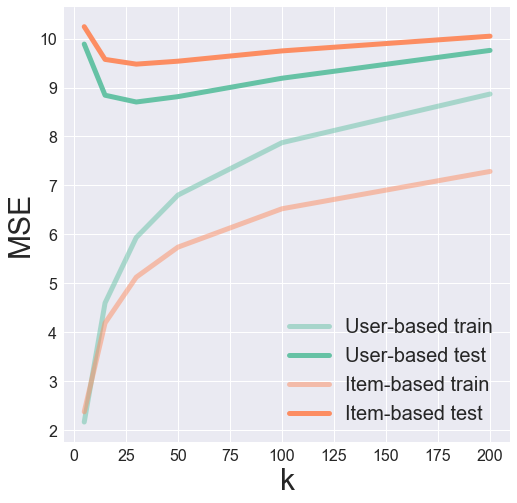

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);